**Definiciones**

In [2]:
# Librerias

import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score,make_scorer
from sklearn.cluster import AgglomerativeClustering, KMeans, MeanShift, DBSCAN
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

**Recopilación de un conjunto diverso de imágenes en diferentes estilos artísticos, a partir del repositorio.**

In [4]:
# Funcion para Cargar la imagen
def load_image(image_path):
    """
    # Carga una imagen cuyo path se ingresa por parametro
    # image_path: String
    #            Ruta a la imagen a cargar
    """
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

In [5]:
def show_selected_images():
    """
    # Muestra algunas de las imagenes seleccionadas
    """    
    fig, ax = plt.subplots(1,6,figsize = (15, 13)) 
    for i in range(0,6):
        path = f'img/img{i}.jpg'
        raw_image = load_image(path)
        ax[i].imshow(raw_image)
        ax[i].axis('off')

**Preparación de los datos, justificando las decisiones tomadas.**

Se define la clase encargada de realizar el pre procesamiento de la imagen con el fin de disminuir el tamaño de la misma y aun mas importante convertirla en un arreglo de 2 dimensiones con valores entre 0 y 1, esto se logra dividiendo cada uno de los valores en 255, el cual es el valor maximo del codigo RGB

In [7]:
# Pre-procesamiento de la imagen:  
class image_processing(BaseEstimator, TransformerMixin):
    
    def __init__(self, factor = 0.1, show=False):
        self.factor = factor
        self.show = show
        self.img_final = None
        
    def fit(self, X, y=None):
        
        return self
    
    def transform(self, X, y=None):
        # Preprocesamiento de la imagen
        
        nuevo_ancho = int(X.shape[1] * self.factor)
        nuevo_alto = int(X.shape[0] * self.factor)
        nuevo_tamanio = (nuevo_ancho, nuevo_alto)
        
        img_submuestreada = cv2.resize(X, nuevo_tamanio)
        
        if self.show:
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.title(f'Imagen Original: {X.shape}')
            plt.imshow(X)
            plt.axis('off')
            plt.subplot(1, 2, 2)
            plt.title(f'Imagen submuestreada: {img_submuestreada.shape}')
            plt.imshow(img_submuestreada)
            plt.axis('off')

        # Darle formato a la imagen (reducción a un array 2D de características)
        img_final = img_submuestreada.reshape((-1, 3)) / 255
        pca = PCA()
        img_final_pca = pca.fit_transform(img_final)
        self.img_final = img_final
        
        return self.img_final

***Construcción de la función que transforma los grupos de colores identificados en un muestrario representativo***

In [9]:
#Funcion para obtener la paleta de colores de una imagen especifica
def plotColorPallete(raw_image, colors):

    """
    # Toma una imagen y un set de colores y grafica la paleta de colores correspondiente
    # raw_image: np.array
    #            Imagen original de la que se extrajo la paleta
    # colors: np.array
    #            colores de la paleta
    """
    colors = np.clip(colors, 0, 1) 
    # Mostrar la imagen original junto con su paleta de colores
    fig, ax = plt.subplots(1,2,figsize = (5, 3))  
    
    ax[0].imshow(raw_image)
    ax[0].set_title('Imagen Original')
    ax[0].axis('off')
    
    # crear la paleta
    for i, color in enumerate(colors):
        ax[1].bar(i, height = 1, color = color, edgecolor = 'none', width = 1)
    
    ax[1].set_title('Paleta de Colores')
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

**Construcción de los diferentes modelos**

***DBSCAN***

In [12]:
class getDBSCANClustering(BaseEstimator, TransformerMixin):
    
    def __init__(self, params=None, n_init=10, n_splits=5, random_state=0, n_jobs=-1, metric = silhouette_score):
        self.params = params if params else {'eps': [0.051250, 0.026875, 0.1],'min_samples': [720,966 ]}
        self.n_init = n_init
        self.n_splits = n_splits
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.metric = metric
        self.eps = None
        self.min_samples = None
        self.silhouette_scores = None
        self.best_score = None
        self.cluster_labels = None
    
    def score_fn(self, modelo, data):
        self.cluster_labels = modelo.fit_predict(data)
        score = silhouette_score(data, self.cluster_labels)
        return score

    def silhouette_plot(self, ax = None):
        scores = self.silhouette_scores
        ax.plot(self.params['eps'], scores,'b', marker='o')
        ax2 = ax.twinx()
        ax2.plot(self.params['min_samples'], scores,'r', marker='x')
        ax.set_xlabel('epsilon')
        ax.set_ylabel('Silhouette Score')
        ax.grid()

    def t_sne_plot(self, img_processed, ax = None):
        tsne = TSNE(n_components = 2,random_state = 0)
        tsne_transformed = tsne.fit_transform(img_processed)  # Reducción a 2D
        # Obtener etiquetas de clusters
        cluster_labels = self.transform(img_processed)
        x_tsne = pd.DataFrame(tsne_transformed, columns=['Dimension 1', 'Dimension 2'])
        K = len(cluster_labels)
        
        # Visualización
        MARKER = ['o', 'v', '1']
        ax.set_xlabel('Representación en dos dimensiones')
        for i in range(K):
            selections = x_tsne[cluster_labels == i]
            ax.scatter(selections['Dimension 1'], selections['Dimension 2'], alpha=0.8, marker=MARKER[i % len(MARKER)], s=5)
            x_mean, y_mean = selections.mean(axis=0)
            ax.text(x_mean, y_mean, str(i), fontdict={'weight': 'bold', 'size': 20})

    def fit(self, X, y = None):
        #------  
        dbscan = DBSCAN(metric='euclidean')
        kfold = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        grid = GridSearchCV(dbscan, self.params, cv=kfold, scoring = self.score_fn, n_jobs=self.n_jobs)
        grid.fit(X)
        self.silhouette_scores = grid.cv_results_['mean_test_score']
        self.best_model_ = grid.best_estimator_
        self.best_score = grid.best_score_
        #------
        return self

    def transform(self, X):
        if self.best_model_ is None:
            raise RuntimeError("Fit debe ser llamado  ya que no se ha ajustado el modelo aun.")
        return self.best_model_.fit_predict(X)

In [13]:
#Construccion del pipeline para DBSCAN
def getDBSCANPipeline():
    return Pipeline(steps=[('preprocessing',image_processing(factor = 0.1)),                           
                           ('clustering', getDBSCANClustering())             
                           ])

In [14]:
def getColors(labels, img_final):
    # Extraer las etiquetas de los clústeres
    # Calcular los centróides de los clústeres
    colors = []
    # Recorre cada clúster identificado (ignora el ruido, que tiene la etiqueta -1)
    for cluster_id in np.unique(labels):
        
        if cluster_id != -1:
            # Seleccionar los puntos del clúster actual
            cluster_points = img_final[labels == cluster_id]

            
            # Calcular el centróide como el promedio de los puntos
            centroid = cluster_points.mean(axis=0)
            #print('centroide')
            #print(centroid)
            colors.append(centroid)
    return np.array(colors)

In [15]:
def getDBSCANColorPallete(img_path, view_in_2d = False): 
    #Cargar la imagen
    raw_image = load_image(img_path)
    # Implementacion del Pipeline
    
    pipe = getDBSCANPipeline()    
    pipe.fit(raw_image)
    
    colors = getColors(pipe.named_steps['clustering'].best_model_.labels_, pipe.named_steps['preprocessing'].img_final)

    print(f'La ruta de la imagen es :{img_path}')
    print(f'El Numero de clusters encontrado es: {len(colors)}')
    # Crear Paleta de colores     
    plotColorPallete(raw_image,colors)

    if view_in_2d:
        plt.figure()
        f, axarr = plt.subplots(1,2)
        axarr[0].set_title('Metodo de la silueta')
        pipe.named_steps['clustering'].silhouette_plot(axarr[0])    
        plt.show()
            
        axarr[1].set_title('T-SNE')
        pipe.named_steps['clustering'].t_sne_plot(pipe.named_steps['preprocessing'].img_final, axarr[1])
        plt.show()
    
    return pipe,raw_image

***MeanShift***

In [17]:
# Funcion de busqueda de hiperparamentros
class getMeanShiftClustering(BaseEstimator, TransformerMixin):
    
    def __init__(self, params=None, n_init=10, n_splits=5, random_state=0, n_jobs=-1, metric = silhouette_score):
        self.params = params if params else {'bandwidth': [0.08, 0.1,0.13]}
        self.n_init = n_init
        self.n_splits = n_splits
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.metric = metric
        self.best_score = None
        self.best_bandwidth = None
        self.silhouette_scores = None
        self.cluster_labels = None
    
    def score_fn(self, modelo, data):
        self.cluster_labels = modelo.fit_predict(data)
        score = silhouette_score(data, self.cluster_labels)
        return score

    def silhouette_plot(self, ax =None):
        scores = self.silhouette_scores
        ax.plot(self.params['bandwidth'], scores, marker='o')
        ax.set_xlabel('Bandwidth')
        ax.set_ylabel('Silhouette Score')
        ax.grid()

    def t_sne_plot(self, img_processed, ax = None):
        tsne = TSNE(n_components = 2,random_state = 0)
        tsne_transformed = tsne.fit_transform(img_processed)  # Reducción a 2D
        # Obtener etiquetas de clusters
        cluster_labels = self.transform(img_processed)
        x_tsne = pd.DataFrame(tsne_transformed, columns=['Dimension 1', 'Dimension 2'])
        K = len(cluster_labels)
        
        # Visualización
        MARKER = ['o', 'v', '1']
        ax.set_xlabel('Representación en dos dimensiones')
        for i in range(K):
            selections = x_tsne[cluster_labels == i]
            ax.scatter(selections['Dimension 1'], selections['Dimension 2'], alpha=0.8, marker=MARKER[i % len(MARKER)], s=5)
            x_mean, y_mean = selections.mean(axis=0)
            ax.text(x_mean, y_mean, str(i), fontdict={'weight': 'bold', 'size': 20})

    def fit(self, X, y = None):
        #------
       
        meanshift = MeanShift(bin_seeding=True, cluster_all = False)
        kfold = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        grid = GridSearchCV(meanshift, self.params, cv=kfold, scoring=self.score_fn, n_jobs=self.n_jobs)
        grid.fit(X)
        self.silhouette_scores = grid.cv_results_['mean_test_score']
        self.best_bandwidth = grid.best_params_['bandwidth']
        self.best_model_ = grid.best_estimator_
        self.best_score = grid.best_score_
        
        #------
        return self

    def transform(self, X):
        if self.best_model_ is None:
            raise RuntimeError("Fit debe ser llamado  ya que no se ha ajustado el modelo aun.")
        return self.best_model_.fit_predict(X)

In [18]:
#Construccion del pipeline para MeanShift
def getMeanShiftPipeline():
    return Pipeline(steps=[('preprocessing',image_processing(factor = 0.1)),                           
                           ('clustering', getMeanShiftClustering())             
                           ])

In [19]:
def getMeanShiftColorPallete(img_path, view_in_2d = False): 
    #Cargar la imagen
    raw_image = load_image(img_path)
    # Implementacion del Pipeline
    
    pipe = getMeanShiftPipeline()
    
    pipe.fit(raw_image)
    
    colors = pipe.named_steps['clustering'].best_model_.cluster_centers_
    print(f'La ruta de la imagen es :{img_path}')
    bandwidth = pipe.named_steps['clustering'].best_bandwidth
    print(f'El bandwidth es: {bandwidth}')
    print(f'El Numero de clusters encontrado es: {len(colors)}')
    
    # Crear Paleta de colores     
    plotColorPallete(raw_image,colors)

    if view_in_2d:
        plt.figure()
        f, axarr = plt.subplots(1,2)
        axarr[0].set_title('Metodo de la silueta')
        pipe.named_steps['clustering'].silhouette_plot(axarr[0])
            
        axarr[1].set_title('T-SNE')
        pipe.named_steps['clustering'].t_sne_plot(pipe.named_steps['preprocessing'].img_final, axarr[1])
        plt.show()
    
    return pipe,raw_image

***Kmeans***

In [21]:
# Funcion de busqueda de hiperparamentros
class getKmeansClustering(BaseEstimator, TransformerMixin):
    
    def __init__(self, params = None, n_init = 10, n_splits = 5, random_state = 0, n_jobs = -1, metric = silhouette_score):
        self.params = params if params else {'n_clusters': [5 ,6 ,7]}
        self.n_init = n_init
        self.n_splits = n_splits
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.metric = metric
        self.best_k = None
        self.silhouette_scores = None
        self.best_score = None
        self.cluster_labels = None
    
    def score_fn(self, modelo, data):
        self.cluster_labels = modelo.fit_predict(data)
        score = silhouette_score(data, self.cluster_labels)
        return score

    def silhouette_plot(self, ax =None):
        scores = self.silhouette_scores
        ax.plot(self.params['n_clusters'], scores, marker='o')
        ax.set_xlabel('Número de clústeres')
        ax.set_ylabel('Silhouette Score')
        ax.grid()

    def t_sne_plot(self, img_processed, ax=None):
        tsne = TSNE(n_components = 2,random_state=0)
        tsne_transformed = tsne.fit_transform(img_processed)  # Reducción a 2D
        # Obtener etiquetas de clusters
        cluster_labels = self.transform(img_processed)
        x_tsne = pd.DataFrame(tsne_transformed, columns=['Dimension 1', 'Dimension 2'])
        K = self.best_k
        
        # Visualización
        MARKER = ['o', 'v', '1']
        ax.set_xlabel('Representación en dos dimensiones')
        for i in range(K):
            selections = x_tsne[cluster_labels == i]
            ax.scatter(selections['Dimension 1'], selections['Dimension 2'], alpha=0.8, marker=MARKER[i % len(MARKER)], s=5)
            x_mean, y_mean = selections.mean(axis=0)
            ax.text(x_mean, y_mean, str(i), fontdict={'weight': 'bold', 'size': 20})

    def fit(self, X, y=None):
        KM = KMeans(n_init=self.n_init)
        kfold = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        grid = GridSearchCV(KM, self.params, cv=kfold, scoring=self.score_fn, n_jobs=self.n_jobs)
        grid.fit(X)
        self.silhouette_scores = grid.cv_results_['mean_test_score']
        self.best_k = grid.best_params_['n_clusters']
        self.best_model_ = grid.best_estimator_
        self.best_score = grid.best_score_
        return self

    def transform(self, X):
        if self.best_model_ is None:
            raise RuntimeError("Fit debe ser llamado ya que no se ha ajustado el modelo aun.")
        return self.best_model_.fit_predict(X)

In [22]:
#Construccion del pipeline para Kmeans
def getKmeansPipeline():
    return Pipeline(steps=[('preprocessing',image_processing(factor = 0.1)),                           
                           ('clustering', getKmeansClustering())             
                           ])

In [23]:
def getKmeansColorPallete(img_path, view_in_2d = False): 
    #Cargar la imagen
    raw_image = load_image(img_path)
    # Implementacion del Pipeline
    
    pipe = getKmeansPipeline()
    
    pipe.fit(raw_image)
    
    colors = pipe.named_steps['clustering'].best_model_.cluster_centers_
    print(f'La ruta de la imagen es :{img_path}')
    K = pipe.named_steps['clustering'].best_k
    print(f'El mejor numero de clusters K es: {K}')
    
    # Crear Paleta de colores     
    plotColorPallete(raw_image,colors)

    if view_in_2d:
        plt.figure()
        f, axarr = plt.subplots(1,2)
        axarr[0].set_title('Metodo de la silueta')
        pipe.named_steps['clustering'].silhouette_plot(axarr[0])
        
        axarr[1].set_title('T-SNE')
        pipe.named_steps['clustering'].t_sne_plot(pipe.named_steps['preprocessing'].img_final, axarr[1])
        plt.show()
    
    return pipe,raw_image

**SELECCIÓN DE MODELO**

(23736, 3)


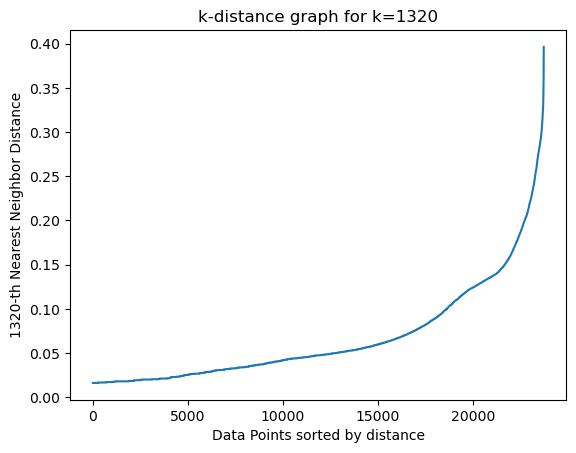

In [25]:
path = 'img/img0.jpg'
raw_image = load_image(path)
img_proce = image_processing()
img_final = img_proce.transform(raw_image)
print(img_final.shape)

k = 1320  
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(img_final)
distances, indices = nbrs.kneighbors(img_final)


distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.xlabel('Data Points sorted by distance')
plt.ylabel(f'{k}-th Nearest Neighbor Distance')
plt.title(f'k-distance graph for k={k}')
plt.show()

La ruta de la imagen es :img/img0.jpg
El mejor numero de clusters K es: 5


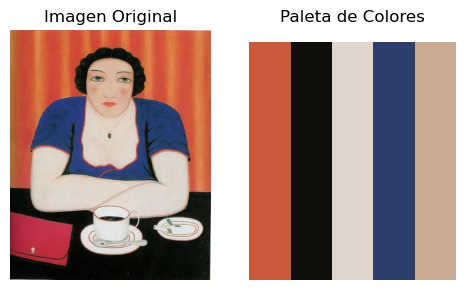

In [26]:
kmeansPipe,img = getKmeansColorPallete(path)

La ruta de la imagen es :img/img0.jpg
El bandwidth es: 0.13
El Numero de clusters encontrado es: 4


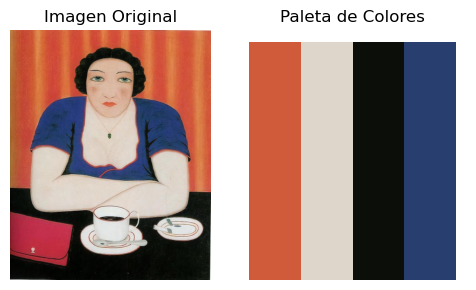

In [27]:
meanShiftPipe,img = getMeanShiftColorPallete(path)

C:\Users\julia\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [0.37464208        nan        nan        nan 0.57324394 0.33117126]
  warnings.warn(


La ruta de la imagen es :img/img0.jpg
El Numero de clusters encontrado es: 4


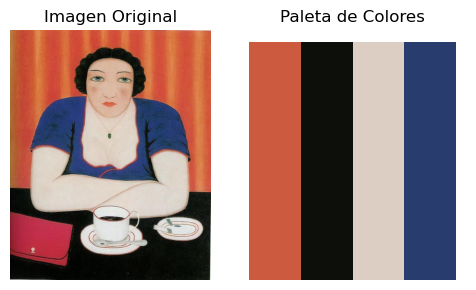

In [28]:
DBSCANPipe,img = getDBSCANColorPallete(path)

In [29]:
score_KMeans = kmeansPipe.named_steps['clustering'].best_score
score_MeanShift = meanShiftPipe.named_steps['clustering'].best_score
score_DBSCAN = DBSCANPipe.named_steps['clustering'].best_score

print(f'La mejor puntuación de silueta obtenida con KMeans fue: {round(score_KMeans,3)}')
print(f'La mejor puntuación de silueta obtenida con Mean Shift fue: {round(score_MeanShift,3)}')
print(f'La mejor puntuación de silueta obtenida con DBSCAN fue: {round(score_DBSCAN,3)}')

La mejor puntuación de silueta obtenida con KMeans fue: 0.713
La mejor puntuación de silueta obtenida con Mean Shift fue: 0.528
La mejor puntuación de silueta obtenida con DBSCAN fue: 0.573


**Resultados**

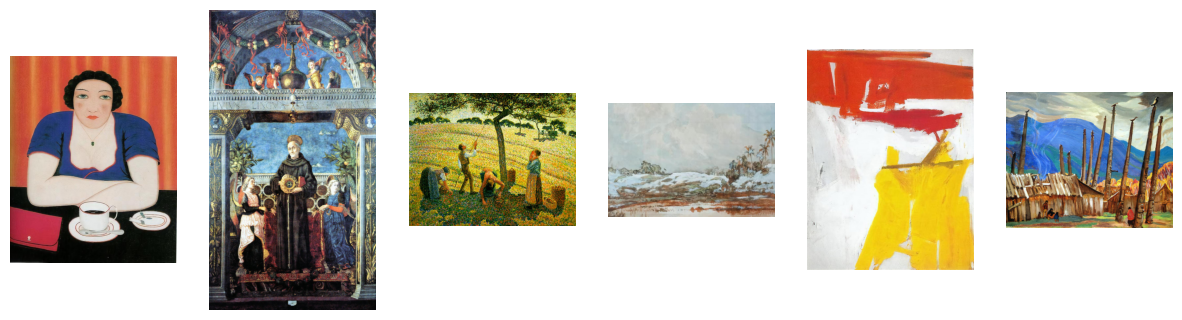

In [31]:
show_selected_images()

La ruta de la imagen es :img/img1.jpg
El mejor numero de clusters K es: 5


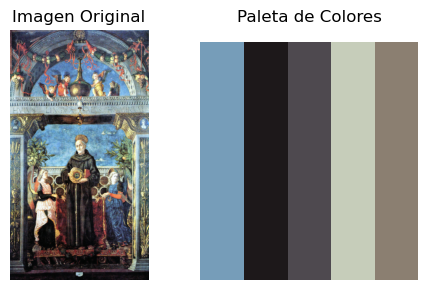

<Figure size 640x480 with 0 Axes>

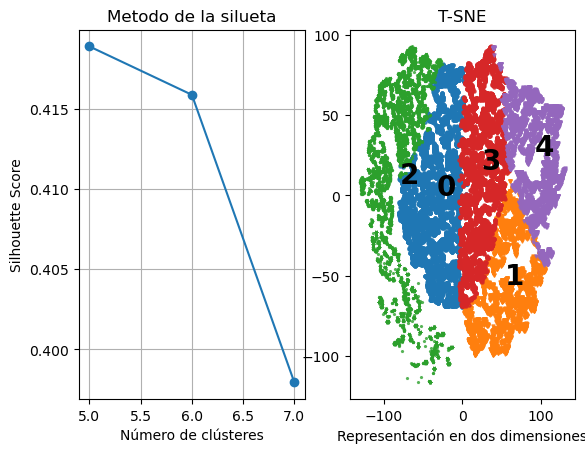

In [32]:
temp = getKmeansColorPallete('img/img1.jpg',view_in_2d = True)

La ruta de la imagen es :img/img2.jpg
El mejor numero de clusters K es: 6


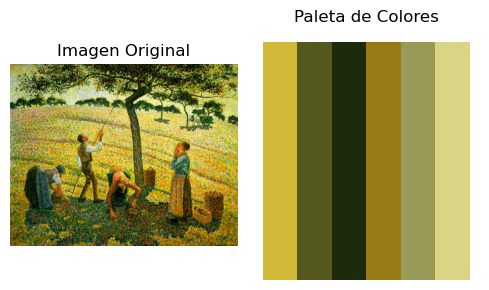

<Figure size 640x480 with 0 Axes>

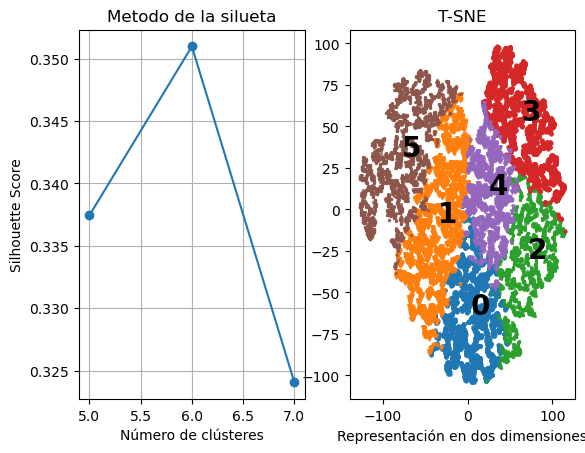

In [33]:
temp = getKmeansColorPallete('img/img2.jpg',view_in_2d = True)

La ruta de la imagen es :img/img3.jpg
El mejor numero de clusters K es: 5


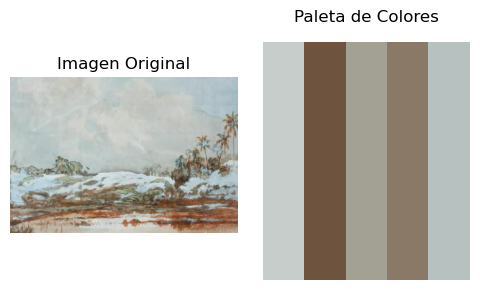

<Figure size 640x480 with 0 Axes>

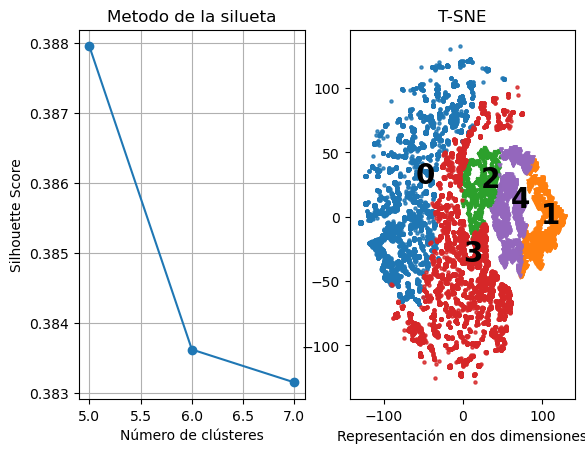

In [34]:
temp = getKmeansColorPallete('img/img3.jpg',view_in_2d = True)

La ruta de la imagen es :img/img4.jpg
El mejor numero de clusters K es: 5


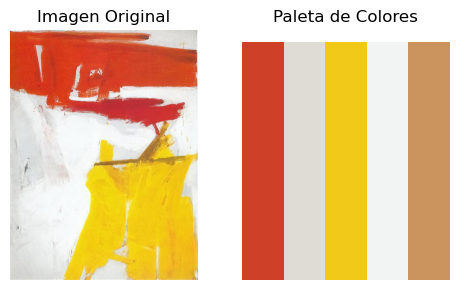

<Figure size 640x480 with 0 Axes>

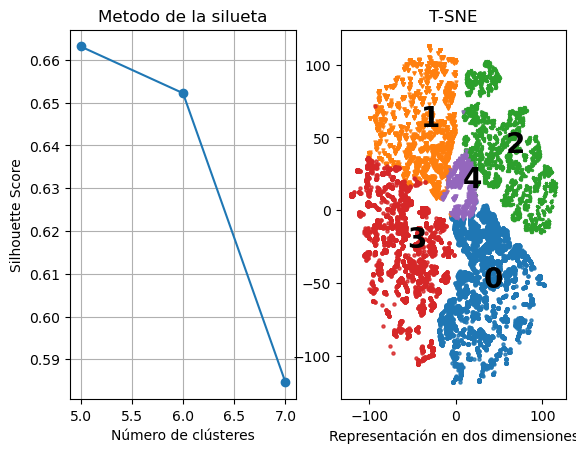

In [35]:
temp = getKmeansColorPallete('img/img4.jpg',view_in_2d = True)

La ruta de la imagen es :img/img5.jpg
El mejor numero de clusters K es: 5


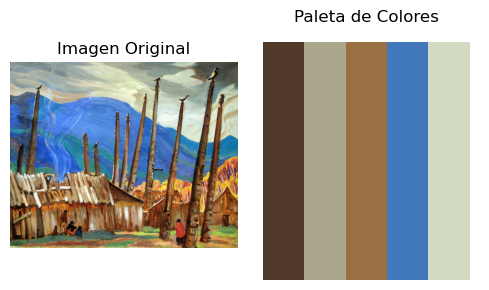

<Figure size 640x480 with 0 Axes>

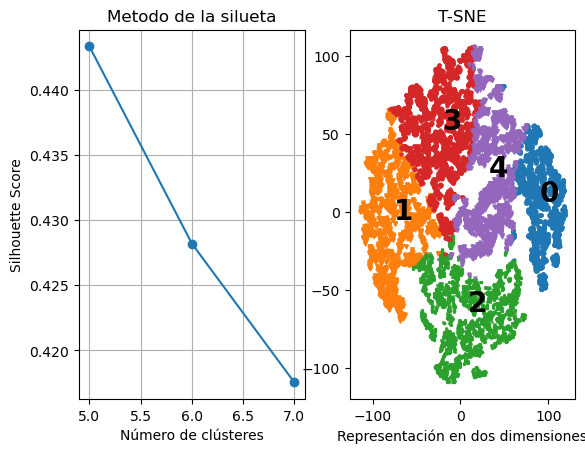

In [36]:
temp = getKmeansColorPallete('img/img5.jpg',view_in_2d = True)

**Discusión y Conclusiones**

Se abordaron tres aproximaciónes al problema propuesto: Mean Shift, DBSCAN, y K-Means

Para los tres modelos se implementó una búsqueda por validación cruzada buscando optimizar el rendimiento de la agrupación basándose en el ajuste de los parámetros de cada modelo. Utilizando imagenes de prueba de entre el grupo de imagenes seleccionadas se extrajo el mejor rendimiento obtenido para cada modelo en cada caso (en la selección de modelo se muestra un ejemplo de este proceso). Al observar que el coeficiente de silueta es mas alto  al utilizar K-Means (en alrededor de 0.2 comparado con los otros dos algoritmos) nos decantamos por escoger este método para el resto de las imagenes a procesar. El método de silueta permite obtener grupos bien definidos lo cual es deseable en este caso para obtener colores mas representativos y que,en lo posible y dependiendo del caso, no sean tan similares entre si.

Un punto importante a favor del método seleccionado (teniendo en cuenta los requerimientos del problema) es que es mas sencillo controlar el número de grupos encontrados por el algoritmo. En KMeans esto se especifica explicitamente como aprametrop mientras que en el caso de Mean Shift y de DBSCAN esto depende de parámetros como el ancho de banda, Épsilon y min_Samples los cuales dependen de la imagen en particular que se esté procesando lo cual se traduce en una implementación más compleja y en un elevado consumo de recursos computacionales que a su vez se traduce en un mayor tiempo de procesamiento.

El procesamiento previo de las imagenes jugó un papel muy importante en el proceso de desarrollo y en la implementación final. El poder modificar el tamaño de los datos con el que se ejecutan los algoritmos frecuentemente fue un factor decisivo al ahorrar tiempo y recursos. Esta etapa de preprocesamiento se estableció como el primer paso del pipeline con el cual se procesa la imagen con el fin de estraer la paleta. El segundo paso es el la extracción de clústeres en sí. El resultado es una función a la que se le ingresa una ruta por parametro y esta da como resultado la paleta de colores.

El resultado de la extracción de la paleta de colores utilizando K-Means se muestra en los resultados. Allí podemos observar una apropiada extracción de paletas de colores para los ejemplos mostrados. Gracias a que el algoritmo implementado ejecuta una búsqueda de grilla para ajustar el parámetro K a cada imagen, es el algoritmo mismo el que encuentra qué cantidad de grupos es la mejor para representar la obra que se le ingresa.

Adicionalmente se muestra una representación bidimensional de la distribución de los grupos (de colores) obtenidos utilizando T-SNE. Vemos en ella como se distribuyen los diferentes clústeres de la imagen y nos sirve para tener una perspectiva más clara de los grupos en cuanto a su diferenciación y diversidad.